In [213]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(31415)

## Creating dataset with reddit features

Making new dataset containing reddit features with home_team and away_team

In [219]:
dt = pd.read_csv('/Users/bradyhong/Downloads/recency_filled_null.csv')

In [220]:
dt[1:2]

,Unnamed: 0,Unnamed: 0.1,game_date,start_season,home_team,away_team,home_score,away_score,winner,halftime_home_goals,...,t-9 home_clearance,t-9 home_tackles,t-9 away_home,t-9 away_attacking,t-9 away_defending,t-9 away_strength,t-9 away_posession,t-9 away_shots_on_target,t-9 away_clearance,t-9 away_tackles
1,1,1,2013-08-17,2013,Swansea City,Manchester United,1,4,A,0,...,27.408568,18.475703,0.008963,1.349552,1.366197,0.032263,50.171447,4.368758,27.09347,18.565301


In [221]:
x = dt.iloc[:,8:9]

In [222]:
z = dt['reddit_home_score']

In [223]:
z1 = dt['reddit_home_post']

In [224]:
z2 = dt['reddit_away_score']

In [225]:
z3 = dt['reddit_away_post']

In [226]:
x2 = dt.iloc[:,4:6]

In [227]:
z4 = pd.concat([z,z1], axis = 1)

In [228]:
z4 = pd.concat([z4,z2], axis = 1)

In [229]:
z4 = pd.concat([z4,z3], axis = 1)

In [1]:
x2 = pd.concat([x2,z4], axis = 1)

NameError: name 'pd' is not defined

## Dropping unneccessary features

In [232]:
dt_drop = dt.drop(['home_strength', 'away_strength',
                   't-1 home_tackles', 't-1 away_tackles',
               't-2 home_tackles', 't-2 away_tackles',
               't-3 home_tackles', 't-3 away_tackles',
               't-4 home_tackles', 't-4 away_tackles',
               't-5 home_tackles', 't-5 away_tackles',
               't-6 home_tackles', 't-6 away_tackles',
               't-7 home_tackles', 't-7 away_tackles',
               't-8 home_tackles', 't-8 away_tackles',
               't-9 home_tackles', 't-9 away_tackles',
                't-1 home_clearance', 't-1 away_clearance',
               't-2 home_clearance', 't-2 away_clearance',
               't-3 home_clearance', 't-3 away_clearance',
               't-4 home_clearance', 't-4 away_clearance',
               't-5 home_clearance', 't-5 away_clearance',
               't-6 home_clearance', 't-6 away_clearance',
               't-7 home_clearance', 't-7 away_clearance',
               't-8 home_clearance', 't-8 away_clearance',
               't-9 home_clearance', 't-9 away_clearance',], axis=1)


## Ranked Probability Score

For each match, we calculated the predicted probabilities for A(away team wins the game), D(draws) and H(home team wins the game) and store these 3 probabilities into a vector p = (p_a, p_d, p_h) with p_a + p_d + p_h = 1.

In [233]:
def rankedProbabilityScore(pred, obs):
    r = len(pred)
    score = 0
    for i in range(0,r):
        sp = 0
        sa = 0
        for j in range(0,i):
            sp = sp + pred[j] 
            sa = sa + obs[j] 
            score = score + (sp-sa)**2
    score == score/(r-1)
    return(score)

## Deteremining the model

Compared K-nearest neighbors and Logistic Regression by lowest mean RPS(Ranked Probability Score) for each game depth. We aggregated recency features with reddit score and total posts and used that dataset.

In [234]:
d = {}
d1 = {}
e = {}
knns = []
log_mean = []
np.random.seed(31415)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
for i in range(67,176,12):
    x1 = dt_drop.iloc[:,67:i]
    x3 = pd.concat([x1,x], axis = 1)
    dt_new = pd.concat([x2,x3], axis = 1)
    X = dt_new.iloc[:, 3:-1].values
    y = dt_new.iloc[:, dt_new.shape[1]-1].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.08)
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    error = []
    p_y = []
    for j in y_test:
        if j == 'A':
            p_y.append(np.array([1, 0, 0]))
        elif j == 'D':
            p_y.append(np.array([0, 1, 0]))
        else:
            p_y.append(np.array([0, 0, 1]))
    # Calculating error for K values between 1 and 200
    for k in range(1, 200):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        pred_i = knn.predict(X_test)
        p_test = knn.predict_proba(X_test)
        rps=[]
        for m in range(len(p_test)):
            temp = rankedProbabilityScore(p_test[m], p_y[m])
            rps.append(temp)
        error.append(np.mean(rps))
    a = min(error)
    knns.append(error.index(a))
    e[i] = error
    d[i] = a
    for n in range(0,len(error)):
        if error[n]==a:
            d1[n] = i
    # Fitting Logistic Regression
    clf = LogisticRegression(random_state=0).fit(X_train, y_train)
    pred_clf = clf.predict_proba(X_test)
    rps_log =[]
    for i in range(len(pred_clf)):
        temp = rankedProbabilityScore(pred_clf[i], p_y[i])
        rps_log.append(temp)
    log_mean.append(np.mean(rps_log))

KeyboardInterrupt: 

In [185]:
# Lowest Mean RPS Score from the logistic regression with each depth (ascending order)
log_mean

[0.6542854418542455,
 0.5832096055690018,
 0.5865956238923363,
 0.5782812083019514,
 0.5798706333958246,
 0.5470528804163014,
 0.6282624947544364,
 0.5535059404846179,
 0.6004269540065419,
 0.733275167909851]

In [186]:
# Best knn out of 200 from each depth (ascending order)
knns

[116, 168, 33, 35, 197, 17, 14, 12, 28, 28]

In [189]:
val = []
for i in d.values():
    val.append(i)

In [188]:
# Lowest Mean RPS Score from knn with each depth (ascending order)
d

{67: 0.6117792838440612,
 79: 0.6229184178540956,
 91: 0.6040533860603065,
 103: 0.5811577554998607,
 115: 0.5845185737530234,
 127: 0.4990485472941614,
 139: 0.5590643274853804,
 151: 0.5456689059927927,
 163: 0.5784467113085926,
 175: 0.6264293313545456}

## Graphs 

Text(0, 0.5, 'Mean RPS')

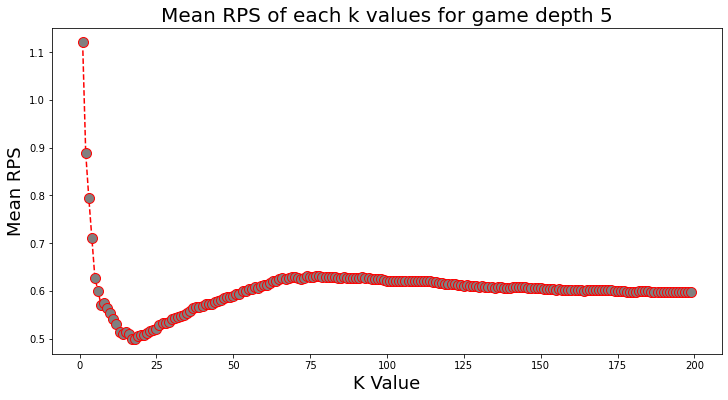

In [190]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 200), e[127], color='red', linestyle='dashed', marker='o',
         markerfacecolor='grey', markersize=10)
plt.title('Mean RPS of each k values for game depth 5', size=20)
plt.xlabel('K Value',size=18)
plt.ylabel('Mean RPS',size=18)

# k = 17

For the k-nearest neighbor, we tested k values from 1 to 200 and evaluated each K with mean RPS. According to Figure 8, k = 17 had the lowest mean RPS = 0.499 when we chose game depth of 5. We have selected 0.08 percent of the data which are 350 games to be our test data.

Text(0, 0.5, 'Mean RPS')

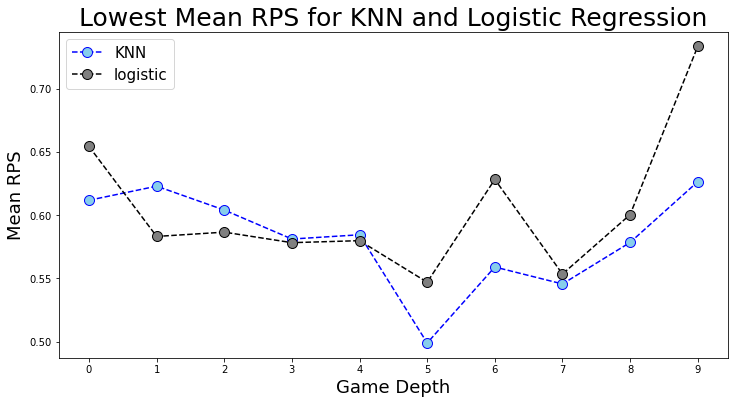

In [191]:
plt.figure(figsize=(12, 6))
plt.plot(range(10), val, color='blue', linestyle='dashed', marker='o',
         markerfacecolor= 'skyblue', markersize=10, label = "KNN")
plt.plot(range(10), log_mean, color='black', linestyle='dashed', marker='o',
         markerfacecolor= 'grey', markersize=10, label = "logistic")
plt.legend(prop={'size': 15})
plt.title('Lowest Mean RPS for KNN and Logistic Regression', size = 25)
plt.xticks(range(10))
plt.xlabel('Game Depth', size = 18)
plt.ylabel('Mean RPS', size = 18)

The best result was using K-nearest neighbors with game depth of 5

In [2]:
`brew install libomp`

SyntaxError: invalid syntax (<ipython-input-2-1223949793e1>, line 1)